In [27]:
# first of all we import the python libraries we need
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns

In [17]:
#TENNIS MATCH DURATION MODEL 
#Best-of-3 and Best-of-5 Models

#First, we Lload all yearly files into one DataFrame
all_matches = pd.concat(
    [pd.read_csv(f"data/atp_matches_{i}.csv") for i in range(2015, 2025)],
    ignore_index=True
)
#Removing unneeded columns
unnecessary = [
    'score','w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms',
    'w_bpSaved','w_bpFaced','l_ace','l_df','l_svpt','l_1stIn','l_1stWon','l_2ndWon',
    'l_SvGms','l_bpSaved','l_bpFaced','winner_name','loser_name','winner_ioc','loser_ioc',
    'winner_entry','loser_entry','tourney_id','tourney_name','tourney_date','winner_seed',
    'loser_seed','winner_ht','loser_ht'
]

df = all_matches.drop(columns=unnecessary, errors='ignore')

In [18]:
#Now we have to encode categorical variables
df = pd.get_dummies(
    df,
    columns=['surface', 'tourney_level'],
    drop_first=False  # keep ALL levels to avoid missing dummy columns
)
#Convert "round" to numeric scale
round_map = {
    'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4,
    'QF': 5, 'SF': 6, 'F': 7, 'BR': 8, 'RR': 9
}

df['round'] = df['round'].map(round_map)

#Drop unmatched round rows (like NaN)
df = df.dropna(subset=['round'])

#Now we remove matches with unrealistic duration
# -------------------------------------------
df = df[df['minutes'] > 20].copy()

#Createing engineered features
df["rank_diff"] = abs(df["winner_rank"] - df["loser_rank"])
df["age_diff"] = abs(df["winner_age"] - df["loser_age"])

In [19]:
#Selecting features (detect dummy columns dynamically)
surface_cols = [col for col in df.columns if col.startswith("surface_")]
tourney_cols = [col for col in df.columns if col.startswith("tourney_level_")]

features = (
    ["winner_rank", "loser_rank", "rank_diff",
     "winner_age", "loser_age", "age_diff",
     "best_of", "round"]
    + surface_cols
    + tourney_cols
)

target = "minutes"

#Splitting into Best-of-3 and Best-of-5
df_best3 = df[df["best_of"] == 3].copy()
df_best5 = df[df["best_of"] == 5].copy()

print("Best-of-3 matches:", len(df_best3))
print("Best-of-5 matches:", len(df_best5))


Best-of-3 matches: 20026
Best-of-5 matches: 4825


In [20]:
#Train/Test Split

X3 = df_best3[features]
y3 = df_best3[target]

X5 = df_best5[features]
y5 = df_best5[target]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

In [21]:
#Random Forest Models
rf3 = RandomForestRegressor(
    n_estimators=300, max_depth=15, min_samples_split=4, random_state=42
)
rf5 = RandomForestRegressor(
    n_estimators=300, max_depth=15, min_samples_split=4, random_state=42
)

rf3.fit(X3_train, y3_train)
rf5.fit(X5_train, y5_train)


RandomForestRegressor(max_depth=15, min_samples_split=4, n_estimators=300,
                      random_state=42)

In [22]:
#Evaluation

y3_pred = rf3.predict(X3_test)
y5_pred = rf5.predict(X5_test)

print("\n=== BEST-OF-3 MODEL ===")
print("MAE:", mean_absolute_error(y3_test, y3_pred))
print("R2 :", r2_score(y3_test, y3_pred))

print("\n=== BEST-OF-5 MODEL ===")
print("MAE:", mean_absolute_error(y5_test, y5_pred))
print("R2 :", r2_score(y5_test, y5_pred))



=== BEST-OF-3 MODEL ===
MAE: 27.560643548838623
R2 : 0.004447104184809092

=== BEST-OF-5 MODEL ===
MAE: 37.95397883995236
R2 : 0.0452637614274517


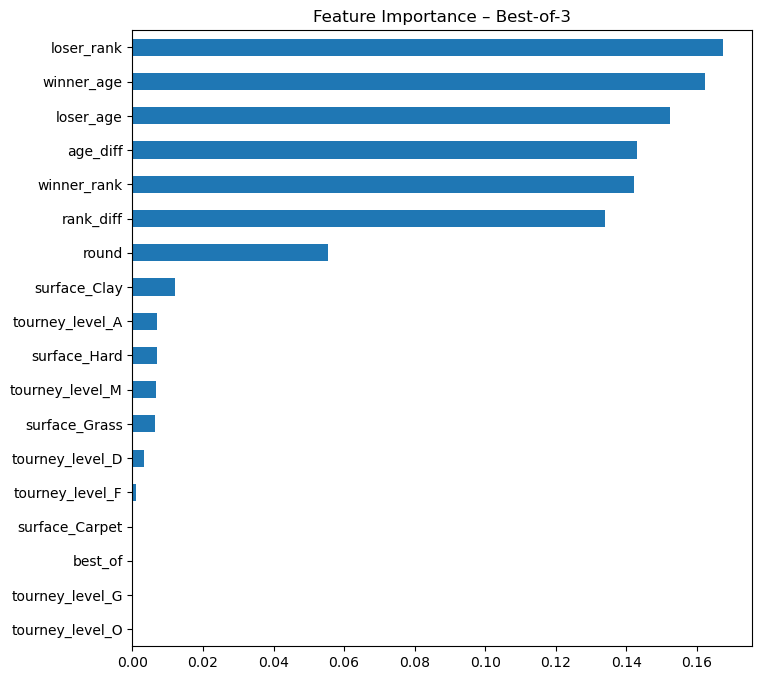

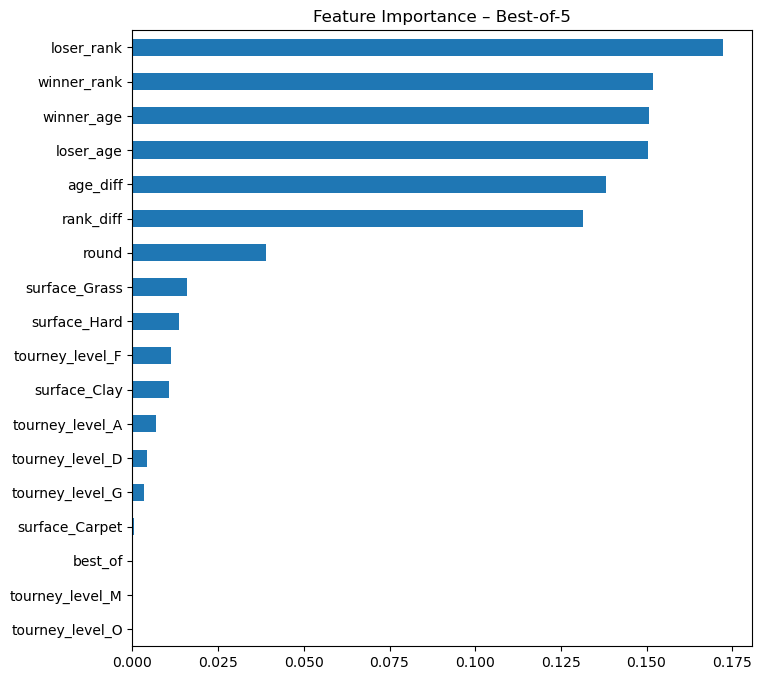

In [23]:

# Feature Importance (plots)
def plot_importances(model, feature_list, title):
    importances = pd.Series(model.feature_importances_, index=feature_list)
    importances.sort_values().plot(kind="barh", figsize=(8, 8))
    plt.title(title)
    plt.show()

plot_importances(rf3, features, "Feature Importance – Best-of-3")
plot_importances(rf5, features, "Feature Importance – Best-of-5")

In [24]:
#Prediction Function (User Inputs -> Match Duration)

def predict_duration(
    winner_rank, loser_rank,
    winner_age, loser_age,
    surface,             # "Hard", "Clay", "Grass"
    tourney_level,       # "A", "G", "M", "O", "F"
    round,               # "R32", "R16", "QF", "SF", "F"
    best_of              # 3 or 5
):
    #Createing empty input row
    row = pd.DataFrame([[0]*len(features)], columns=features)

    #numeric values
    row["winner_rank"] = winner_rank
    row["loser_rank"] = loser_rank
    row["rank_diff"] = abs(winner_rank - loser_rank)

    row["winner_age"] = winner_age
    row["loser_age"] = loser_age
    row["age_diff"] = abs(winner_age - loser_age)

    row["best_of"] = best_of

    #round encoding
    round_map = {
        'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4,
        'QF': 5, 'SF': 6, 'F': 7, 'BR': 8, 'RR': 9
    }
    row["round"] = round_map.get(round, 3)  # default R32

    #surface one-hot
    for col in surface_cols:
        row[col] = 1 if col == f"surface_{surface}" else 0

    #tourney_level one-hot
    for col in tourney_cols:
        row[col] = 1 if col == f"tourney_level_{tourney_level}" else 0

    #choose model based on best_of
    model = rf3 if best_of == 3 else rf5

    prediction = model.predict(row)[0]
    print(f"Predicted match duration: {prediction:.1f} minutes")

    return prediction



In [26]:
predict_duration(
    winner_rank=3,
    loser_rank=50,
    winner_age=27,
    loser_age=31,
    surface="Hard",
    tourney_level="A",
    round="QF",
    best_of=3
)


Predicted match duration: 87.3 minutes


np.float64(87.34107711043578)

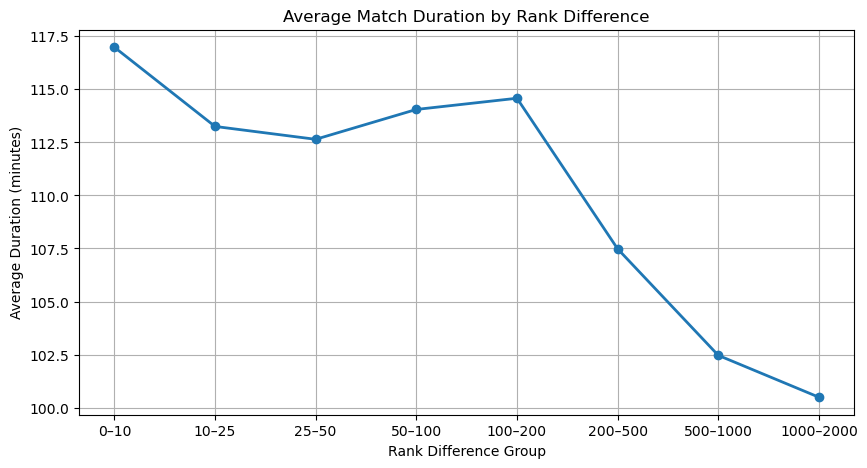

In [36]:
df["rank_diff_group"] = pd.cut(
    df["rank_diff"],
    bins=[0,10,25,50,100,200,500,1000,2000],
    labels=["0–10","10–25","25–50","50–100","100–200","200–500","500–1000","1000–2000"],
    include_lowest=True
)
avg_duration = df.groupby("rank_diff_group", observed=True)["minutes"].mean()

#Plot
plt.figure(figsize=(10,5))
avg_duration.plot(kind="line", marker="o", linewidth=2)

plt.title("Average Match Duration by Rank Difference")
plt.xlabel("Rank Difference Group")
plt.ylabel("Average Duration (minutes)")
plt.grid(True)

plt.show()